In [1]:
# !pip install pycocotools --quiet
# !git clone https://github.com/pytorch/vision.git
# !git checkout v0.3.0

# !cp vision/references/detection/utils.py ./
# !cp vision/references/detection/transforms.py ./
# !cp vision/references/detection/coco_eval.py ./
# !cp vision/references/detection/engine.py ./
# !cp vision/references/detection/coco_utils.py ./

In [2]:
import os
import numpy as np
import torch as tc
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm.notebook import tqdm, trange
import pickle

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# these are the helper libraries imported.
from engine import train_one_epoch, evaluate
import utils
# import transforms as T
#import cv2
from WishDataSet import WishDataSet, get_transform
from wish_utils import *

In [3]:
tc.__version__

'2.2.1+cu118'

In [4]:
tc.cuda.is_available(), tc.cuda.device_count()

(True, 2)

In [5]:
!nvidia-smi

Thu Mar  7 11:28:35 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.14              Driver Version: 550.54.14      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Quadro RTX 4000                Off |   00000000:04:00.0 Off |                  N/A |
| 30%   26C    P8              7W /  125W |     253MiB /   8192MiB |      9%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [6]:
tc.cuda.current_device(), tc.cuda.device(0), tc.cuda.get_device_name()

(0, <torch.cuda.device at 0x7f0b33ce8700>, 'Quadro RTX 4000')

In [7]:
# f = "/home/wj1132075/Desktop/CNN_Model_Data/Annotations/annot_56_25.pickle"
# with open(f, 'rb') as handle:
#     annot_dict = pickle.load(handle)
#     bin_data = np.load(annot_dict['nparr_path'])['arr_0']
#     # img_res = np.tile(bin_data[:,:,None], 3)
#     bin_data = cv2.normalize(bin_data, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    
#     # img_res = cv2.resize(img_res, (128, 128), cv2.INTER_AREA)

In [8]:
# bin_data.shape

In [9]:
# np.max(bin_data), np.min(bin_data)

In [10]:
# cv2.imshow('let see', bin_data)
# cv2.waitKey(0)
# cv2.destroyAllWindoes()

In [11]:
# img_res = cv2.resize(img_res, (128, 128), cv2.INTER_AREA)

In [12]:
annotations_dir = "/home/wj1132075/Desktop/CNN_Model_Data/PeakDataInFullRange/Annotations/"
ds = WishDataSet(annotations_dir)
len(ds)

15376

In [13]:
im, tar = ds[0]
type(im), type(tar)

(numpy.ndarray, dict)

In [14]:
im.shape

(1520, 128, 3)

In [15]:
tar

{'boxes': tensor([[ 0., 63.,  7., 67.]]),
 'labels': tensor([1]),
 'area': tensor([28.]),
 'iscrowd': tensor([0]),
 'image_id': 0}

In [16]:
# t = A.Compose([
#                A.augmentations.geometric.resize.Resize(128, 128, p=1),
#                A.HorizontalFlip(0.5),
#                ToTensorV2(p=1.0)], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [17]:
# new = t(image = im, bboxes = tar['boxes'], labels = tar['labels'])
# new

In [18]:
# new['image'].shape

In [19]:
# transform = A.Compose(
#     [        
#         A.augmentations.geometric.resize.Resize(128, 128, p=1),
#         # A.VerticalFlip(p=0.5), 
#         ToTensorV2(p=1.0)
#     ],
#     bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels'])
# )

In [20]:
# transform = A.Compose(
#     [       
#         A.VerticalFlip(0.5),
#         A.augmentations.geometric.resize.Resize(128, 128, p=1),
#         ToTensorV2(p=1.0)
#     ], 
#     bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

# for i in trange(5):
#     new = transform(image = im, bboxes = tar['boxes'], labels = tar['labels'])
#     print(new['bboxes'])
#     plot_bin(new['image'][0,...], new['bboxes'], 0)

In [21]:
# plot_img_bbox(im, tar)

### See bins and boxes

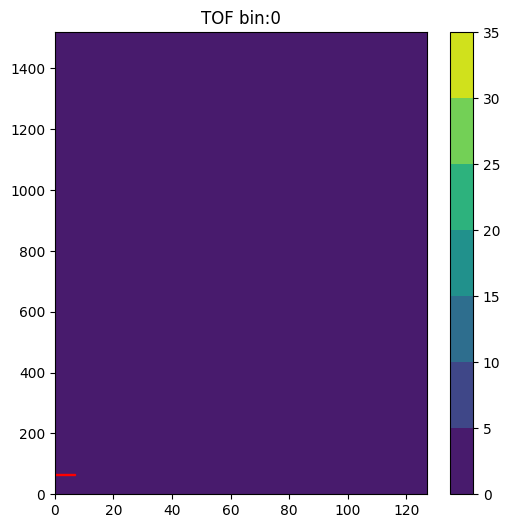

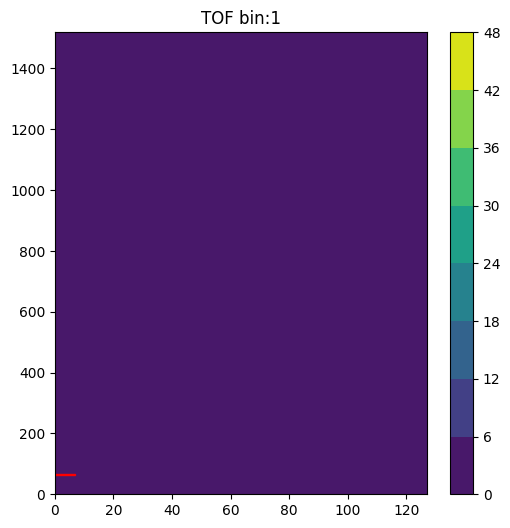

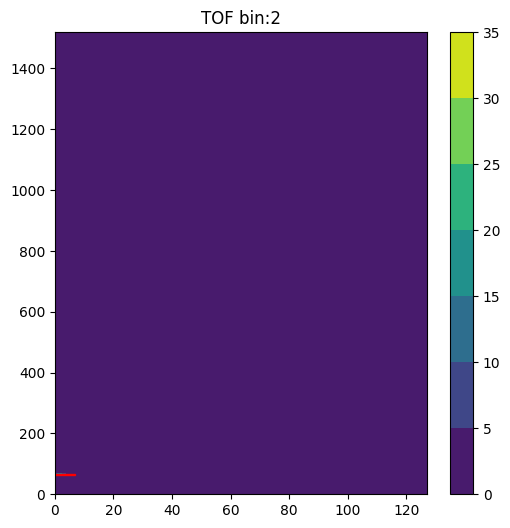

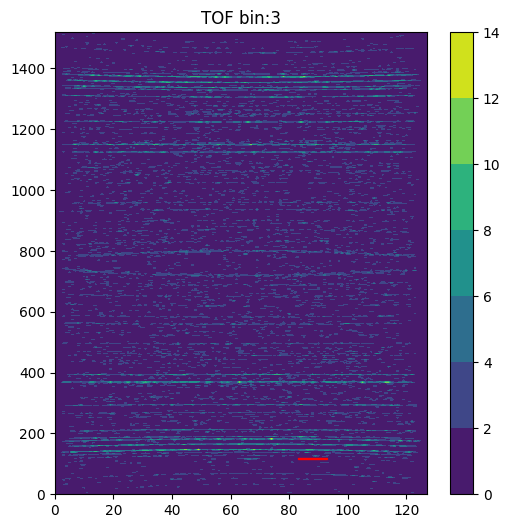

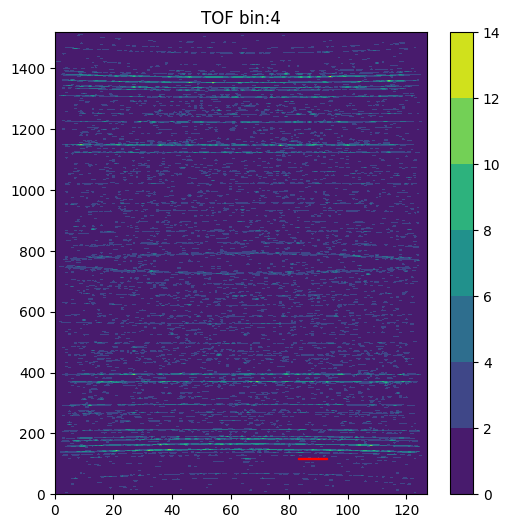

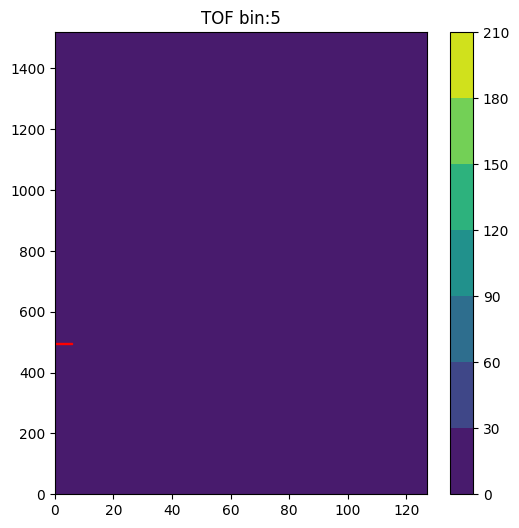

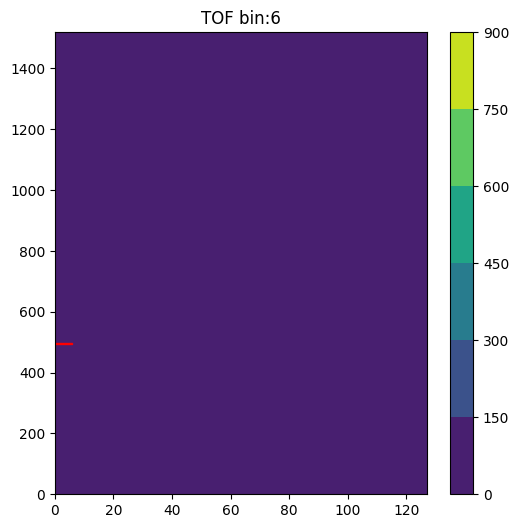

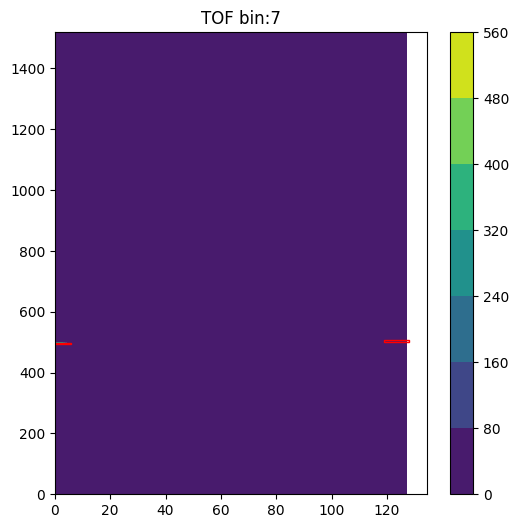

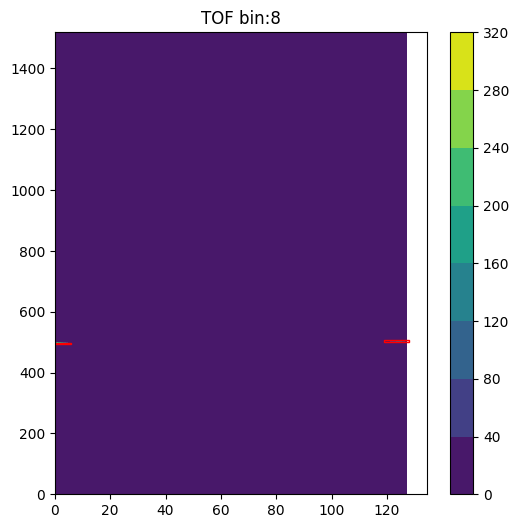

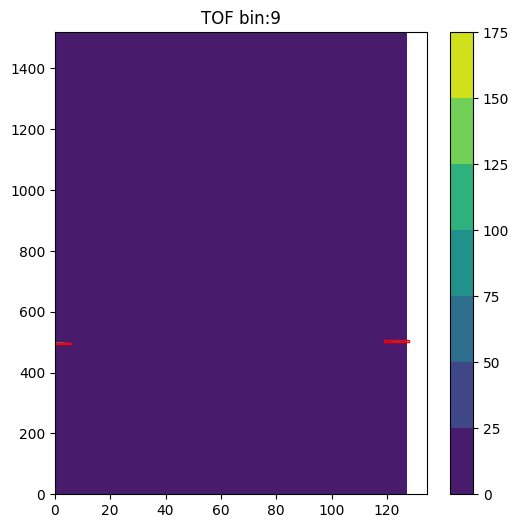

In [22]:
i=0
for (im, tar) in ds:
    plot_bin(im[:,:,0], tar['boxes'], i)
    i+=1
    if i == 10:
        break

### Calculate the stats

dl = tc.utils.data.DataLoader(ds, batch_size=100, shuffle=False, num_workers=2, collate_fn=utils.collate_fn)
stats = get_stats(dl)
stats

In [23]:
# statsold = (np.array([1.26653515, 1.26653515, 1.26653515]), np.array([4.59509826, 4.59509826, 4.59509826]))
stats = (np.array([1.47101333, 1.47101333, 1.47101333]), np.array([4.50738405, 4.50738405, 4.50738405]))
stats

(array([1.47101333, 1.47101333, 1.47101333]),
 array([4.50738405, 4.50738405, 4.50738405]))

### Training and test data sets

In [24]:
# stats=None
dataset = WishDataSet(annotations_dir, transforms=get_transform(train=True))
dataset_test = WishDataSet(annotations_dir, transforms=get_transform(train=False))

In [25]:
# split the dataset in train and test set
tc.manual_seed(1)
indices = tc.randperm(len(dataset)).tolist()

# train test split
test_split = 0.2
tsize = int(len(dataset)*test_split)
dataset = tc.utils.data.Subset(dataset, indices[:-tsize])
dataset_test = tc.utils.data.Subset(dataset_test, indices[-tsize:])

# define training and validation data loaders
data_loader = tc.utils.data.DataLoader(dataset, batch_size=8, shuffle=True, num_workers=2, collate_fn=utils.collate_fn)
data_loader_test = tc.utils.data.DataLoader(dataset_test, batch_size=8, shuffle=False, num_workers=2, collate_fn=utils.collate_fn)

### Model Training

In [26]:
# to train on gpu if selected.
device = tc.device('cuda') if tc.cuda.is_available() else tc.device('cpu')

num_classes = 2

# model = get_object_detection_model(num_classes, pretrained=False)
model = get_model(model=torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True),
                 num_classes=2,
                 stats=stats)

/home/wj1132075/.conda/envs/cuda_1/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/wj1132075/.conda/envs/cuda_1/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [27]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[1.47101333 1.47101333 1.47101333], std=[4.50738405 4.50738405 4.50738405])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.

In [28]:
freeze_to(model, False)

In [29]:
device

device(type='cuda')

In [30]:
[p.requires_grad for p in model.parameters()]

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True]

In [31]:
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = tc.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = tc.optim.lr_scheduler.StepLR(optimizer, 
                                            step_size=3,
                                            gamma=0.1)# to train on gpu if selected.

In [32]:
len(params)

72

In [33]:
lr_scheduler

### Training 

In [34]:
num_epochs = 20
for epoch in trange(num_epochs):
    # training for one epoch
    print(f"starting epoch {epoch}")
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=50)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

  0%|          | 0/20 [00:00<?, ?it/s]

starting epoch 0
Epoch: [0]  [   0/1538]  eta: 2:40:23  lr: 0.000010  loss: 4.6504 (4.6504)  loss_classifier: 0.5219 (0.5219)  loss_box_reg: 0.0134 (0.0134)  loss_objectness: 3.1373 (3.1373)  loss_rpn_box_reg: 0.9777 (0.9777)  time: 6.2569  data: 0.7523  max mem: 2127
Epoch: [0]  [  50/1538]  eta: 0:13:04  lr: 0.000260  loss: 0.4505 (1.0569)  loss_classifier: 0.0740 (0.1956)  loss_box_reg: 0.0593 (0.0427)  loss_objectness: 0.0531 (0.3672)  loss_rpn_box_reg: 0.2429 (0.4515)  time: 0.4165  data: 0.0254  max mem: 2323
Epoch: [0]  [ 100/1538]  eta: 0:11:21  lr: 0.000509  loss: 0.2522 (0.6840)  loss_classifier: 0.0352 (0.1187)  loss_box_reg: 0.0588 (0.0514)  loss_objectness: 0.0448 (0.2114)  loss_rpn_box_reg: 0.1290 (0.3026)  time: 0.4232  data: 0.0283  max mem: 2323
Epoch: [0]  [ 150/1538]  eta: 0:10:34  lr: 0.000759  loss: 0.3226 (0.5524)  loss_classifier: 0.0251 (0.0899)  loss_box_reg: 0.0439 (0.0518)  loss_objectness: 0.0316 (0.1524)  loss_rpn_box_reg: 0.2123 (0.2584)  time: 0.4257  dat

#### Save the trained model

In [35]:
model_save_path = '/mnt/ceph/home/wj1132075/Desktop/CNN_Model_Data/fasterrcnn_resnet50_fpn_pretrained_retrained_full_4x10box.pt'

In [36]:
tc.save(model.state_dict(), model_save_path)

In [37]:
# pick one image from the test set
img, target = dataset_test[5]
# put the model in evaluation mode
model.eval()
with tc.no_grad():
    prediction = model([img.to(device)])[0]
    
print('predicted #boxes: ', len(prediction['labels']))
print('real #boxes: ', len(target['labels']))

predicted #boxes:  3
real #boxes:  2


In [38]:
prediction

{'boxes': tensor([[101.6766, 299.7610, 111.6232, 303.7491],
         [ 32.9103, 302.9521,  42.8774, 306.9865],
         [101.6257, 298.5028, 111.4988, 302.3014]], device='cuda:0'),
 'labels': tensor([1, 1, 1], device='cuda:0'),
 'scores': tensor([0.9680, 0.9628, 0.0594], device='cuda:0')}

In [39]:
target

{'boxes': tensor([[ 32., 301.,  42., 305.],
         [101., 300., 111., 304.]]),
 'labels': tensor([1, 1]),
 'area': tensor([40., 40.]),
 'iscrowd': tensor([0, 0]),
 'image_id': 1745}

In [40]:
nms_prediction = apply_nms(prediction, iou_thresh=0.2)
nms_prediction

{'boxes': tensor([[101.6766, 299.7610, 111.6232, 303.7491],
         [ 32.9103, 302.9521,  42.8774, 306.9865]], device='cuda:0'),
 'labels': tensor([1, 1], device='cuda:0'),
 'scores': tensor([0.9680, 0.9628], device='cuda:0')}

In [41]:
img.shape

torch.Size([3, 1520, 128])

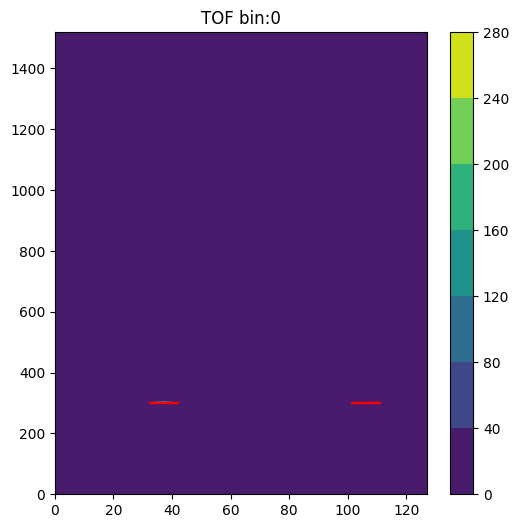

In [42]:
plot_bin(img[0,:,:], target['boxes'], 0)

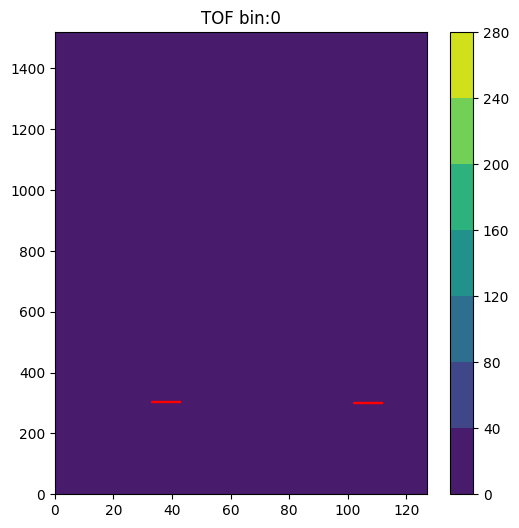

In [43]:
plot_bin(img[0,:,:], nms_prediction['boxes'].cpu(), 0)

### Load the model from disk

In [50]:
r_model = get_model(model=torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True),
                 num_classes=2,
                 stats=stats)
# r_model.load_state_dict(tc.load(model_save_path))
r_model.load_state_dict(tc.load(model_save_path, map_location=tc.device('cpu')))
r_model = r_model.to(device)

In [51]:
img, target = dataset_test[100]
r_model.eval()
with tc.no_grad():
    prediction = r_model([img.to(device)])[0]
prediction

{'boxes': tensor([[  99.8420, 1213.2285,  109.8489, 1217.2908],
         [  20.4581, 1208.2036,   30.4161, 1212.2654]], device='cuda:0'),
 'labels': tensor([1, 1], device='cuda:0'),
 'scores': tensor([0.9864, 0.8500], device='cuda:0')}

In [52]:
nms_prediction = apply_nms(prediction, iou_thresh=0.2)
nms_prediction

{'boxes': tensor([[  99.8420, 1213.2285,  109.8489, 1217.2908],
         [  20.4581, 1208.2036,   30.4161, 1212.2654]], device='cuda:0'),
 'labels': tensor([1, 1], device='cuda:0'),
 'scores': tensor([0.9864, 0.8500], device='cuda:0')}

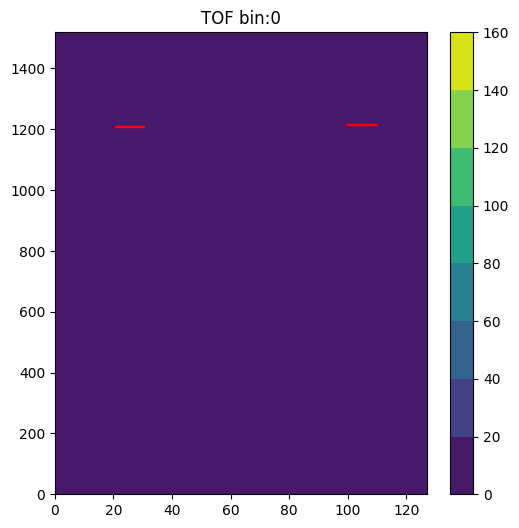

In [53]:
plot_bin(img[0,:,:], nms_prediction['boxes'].cpu(), 0)

{'boxes': tensor([[  23.4256, 1467.0968,   33.4780, 1471.0862],
        [  56.9541,  218.4022,   66.9287,  222.4250],
        [  44.0197,  217.7820,   53.9953,  221.6570],
        [ 118.8116, 1469.1761,  128.0000, 1473.3021],
        [  30.4541,  217.4917,   40.3382,  221.4277],
        [  71.2414,  219.5828,   81.1468,  223.5327],
        [ 118.7868, 1470.7615,  128.0000, 1474.9017],
        [ 118.8442, 1467.6389,  128.0000, 1471.7748]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9843, 0.9767, 0.9657, 0.7328, 0.1163, 0.0925, 0.0858, 0.0630],
       device='cuda:0')}
{'boxes': tensor([[  23.4256, 1467.0968,   33.4780, 1471.0862],
        [  56.9541,  218.4022,   66.9287,  222.4250],
        [  44.0197,  217.7820,   53.9953,  221.6570],
        [ 118.8116, 1469.1761,  128.0000, 1473.3021],
        [  30.4541,  217.4917,   40.3382,  221.4277],
        [  71.2414,  219.5828,   81.1468,  223.5327]], device='cuda:0'), 'labels': tensor(

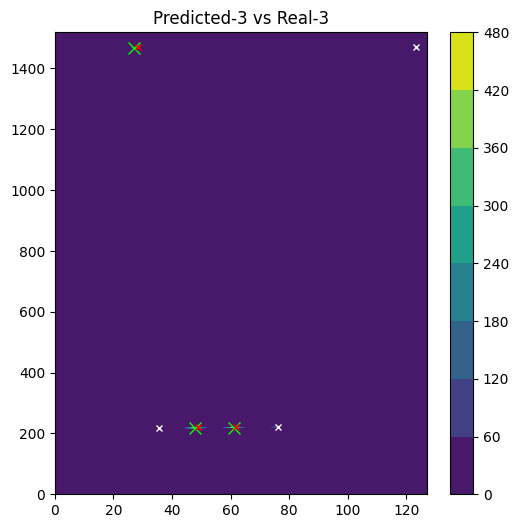

{'boxes': tensor([[ 96.6051,  58.7366, 106.5136,  62.7152],
        [ 35.2165,  60.4263,  45.2095,  64.3593],
        [ 49.9566,  62.5109,  60.0541,  66.3164],
        [ 35.3237,  59.0704,  45.1618,  62.8039],
        [ 49.4427,  61.2456,  59.5378,  65.0990]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9362, 0.8484, 0.1710, 0.0879, 0.0806], device='cuda:0')}
{'boxes': tensor([[ 96.6051,  58.7366, 106.5136,  62.7152],
        [ 35.2165,  60.4263,  45.2095,  64.3593],
        [ 49.9566,  62.5109,  60.0541,  66.3164]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9362, 0.8484, 0.1710], device='cuda:0')}
prediction=tensor([ 96.6051,  58.7366, 106.5136,  62.7152]) score=0.9361574053764343
Prediction coordinate x=101.5593490600586 y=60.72590255737305
prediction=tensor([35.2165, 60.4263, 45.2095, 64.3593]) score=0.8484231233596802
Prediction coordinate x=40.212989807128906 y=62.392791748046875
prediction=ten

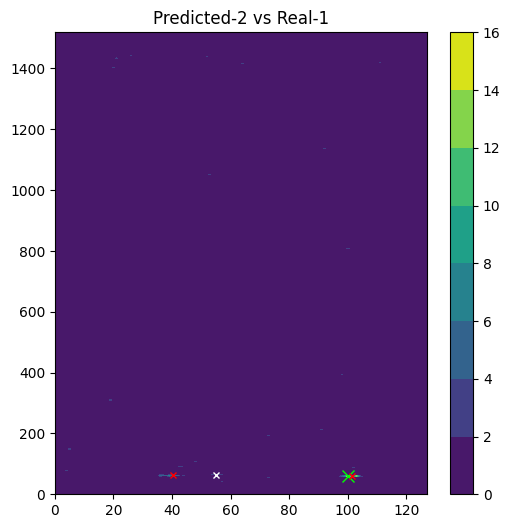

{'boxes': tensor([[  0.9588, 731.6943,  10.8342, 735.6014],
        [ 78.4814, 730.5487,  88.4812, 734.5580],
        [102.3792, 729.9600, 112.4175, 734.0739]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9926, 0.9845, 0.8467], device='cuda:0')}
{'boxes': tensor([[  0.9588, 731.6943,  10.8342, 735.6014],
        [ 78.4814, 730.5487,  88.4812, 734.5580],
        [102.3792, 729.9600, 112.4175, 734.0739]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9926, 0.9845, 0.8467], device='cuda:0')}
prediction=tensor([  0.9588, 731.6943,  10.8342, 735.6014]) score=0.9925623536109924
Prediction coordinate x=5.896487236022949 y=733.6478271484375
prediction=tensor([ 78.4814, 730.5487,  88.4812, 734.5580]) score=0.9844673871994019
Prediction coordinate x=83.48133850097656 y=732.5533447265625
prediction=tensor([102.3792, 729.9600, 112.4175, 734.0739]) score=0.8467410206794739
Prediction coordinate x=107.39837646484375 y=732.

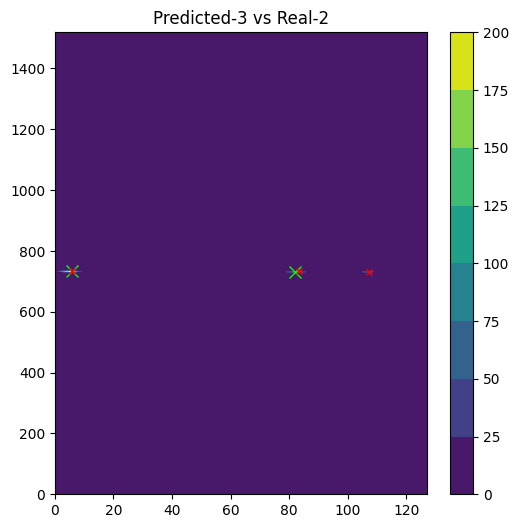

{'boxes': tensor([[ 98.9231, 338.5801, 108.9264, 342.6082],
        [ 22.9724, 343.4626,  32.9233, 347.4691],
        [ 42.4495, 342.0678,  52.5451, 346.1652]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9837, 0.9831, 0.0764], device='cuda:0')}
{'boxes': tensor([[ 98.9231, 338.5801, 108.9264, 342.6082],
        [ 22.9724, 343.4626,  32.9233, 347.4691],
        [ 42.4495, 342.0678,  52.5451, 346.1652]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9837, 0.9831, 0.0764], device='cuda:0')}
prediction=tensor([ 98.9231, 338.5801, 108.9264, 342.6082]) score=0.9837033748626709
Prediction coordinate x=103.92475891113281 y=340.5941162109375
prediction=tensor([ 22.9724, 343.4626,  32.9233, 347.4691]) score=0.9830583333969116
Prediction coordinate x=27.947860717773438 y=345.4658508300781
prediction=tensor([ 42.4495, 342.0678,  52.5451, 346.1652]) score=0.076384536921978
----->Ignoring the prediction at x=47.4973144531

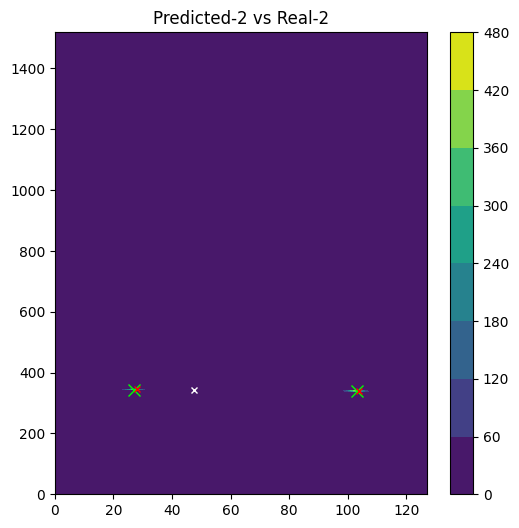

{'boxes': tensor([[5.2621e+01, 1.1515e+02, 6.2673e+01, 1.1906e+02],
        [9.0761e+01, 2.0923e+02, 1.0090e+02, 2.1329e+02],
        [4.0044e+01, 1.1472e+02, 4.9902e+01, 1.1859e+02],
        [0.0000e+00, 2.0884e+02, 9.0727e+00, 2.1275e+02],
        [2.0889e-01, 2.1013e+02, 8.8164e+00, 2.1409e+02],
        [4.1518e+01, 1.1603e+02, 5.1343e+01, 1.1994e+02]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9032, 0.8442, 0.5860, 0.5728, 0.1109, 0.0910], device='cuda:0')}
{'boxes': tensor([[ 52.6205, 115.1482,  62.6729, 119.0615],
        [ 90.7609, 209.2257, 100.9024, 213.2875],
        [ 40.0436, 114.7165,  49.9020, 118.5884],
        [  0.0000, 208.8448,   9.0727, 212.7466]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9032, 0.8442, 0.5860, 0.5728], device='cuda:0')}
prediction=tensor([ 52.6205, 115.1482,  62.6729, 119.0615]) score=0.9031673073768616
Prediction coordinate x=57.646690368652344 y=117.10

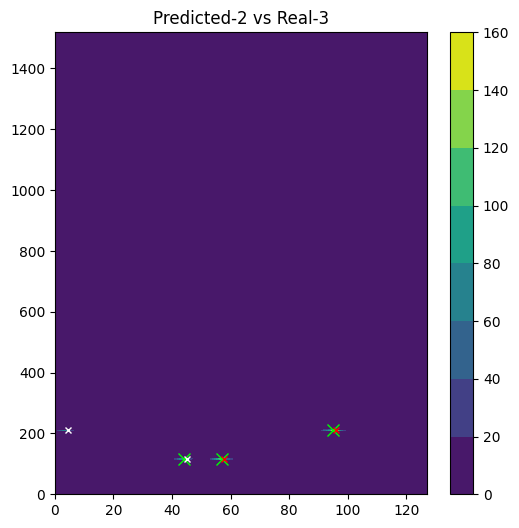

{'boxes': tensor([[101.6766, 299.7610, 111.6232, 303.7491],
        [ 32.9103, 302.9521,  42.8774, 306.9865],
        [101.6257, 298.5028, 111.4988, 302.3014]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9680, 0.9628, 0.0594], device='cuda:0')}
{'boxes': tensor([[101.6766, 299.7610, 111.6232, 303.7491],
        [ 32.9103, 302.9521,  42.8774, 306.9865]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9680, 0.9628], device='cuda:0')}
prediction=tensor([101.6766, 299.7610, 111.6232, 303.7491]) score=0.9680455923080444
Prediction coordinate x=106.64991760253906 y=301.75506591796875
prediction=tensor([ 32.9103, 302.9521,  42.8774, 306.9865]) score=0.9627825617790222
Prediction coordinate x=37.89386749267578 y=304.96929931640625


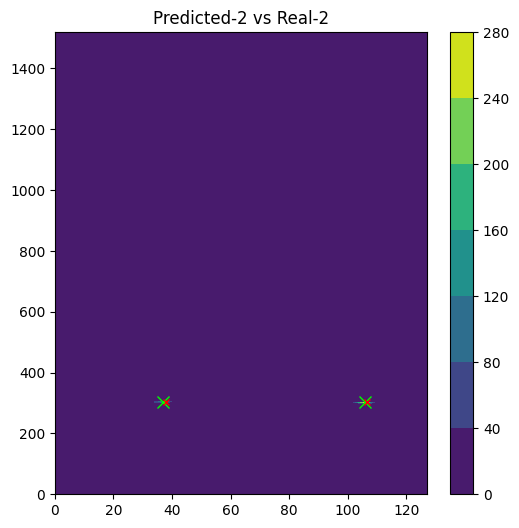

{'boxes': tensor([[ 26.4352, 160.5835,  36.3268, 164.6180],
        [ 83.0580, 157.1325,  93.0426, 161.2248]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9787, 0.9629], device='cuda:0')}
{'boxes': tensor([[ 26.4352, 160.5835,  36.3268, 164.6180],
        [ 83.0580, 157.1325,  93.0426, 161.2248]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9787, 0.9629], device='cuda:0')}
prediction=tensor([ 26.4352, 160.5835,  36.3268, 164.6180]) score=0.9786792397499084
Prediction coordinate x=31.381027221679688 y=162.60073852539062
prediction=tensor([ 83.0580, 157.1325,  93.0426, 161.2248]) score=0.9629101157188416
Prediction coordinate x=88.05027770996094 y=159.17864990234375


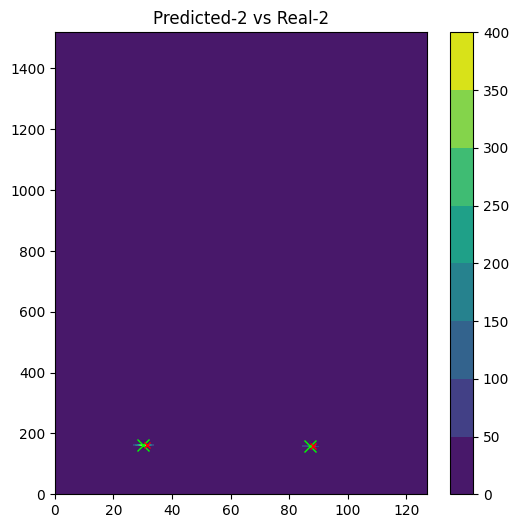

{'boxes': tensor([[ 97.4480, 969.4937, 107.4144, 973.5404],
        [ 30.6588, 972.6519,  40.5837, 976.6190],
        [ 30.7278, 973.9519,  40.7261, 977.9149],
        [ 30.5775, 971.0201,  40.4588, 975.0621]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9548, 0.7902, 0.1276, 0.1158], device='cuda:0')}
{'boxes': tensor([[ 97.4480, 969.4937, 107.4144, 973.5404],
        [ 30.6588, 972.6519,  40.5837, 976.6190]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9548, 0.7902], device='cuda:0')}
prediction=tensor([ 97.4480, 969.4937, 107.4144, 973.5404]) score=0.9547761678695679
Prediction coordinate x=102.43115234375 y=971.51708984375
prediction=tensor([ 30.6588, 972.6519,  40.5837, 976.6190]) score=0.790241003036499
Prediction coordinate x=35.62126159667969 y=974.6354370117188


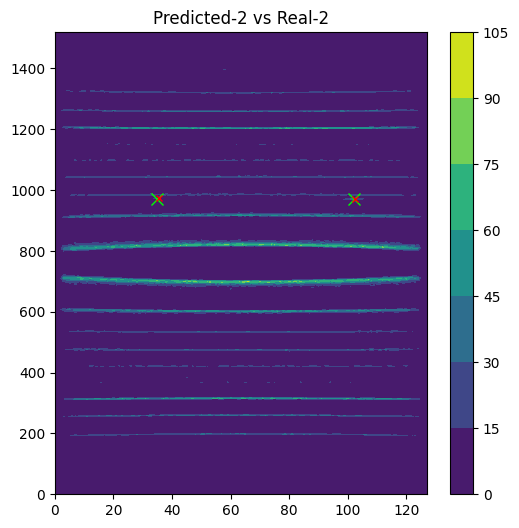

In [54]:
r_model.eval()
probe = 0
for img, target in data_loader_test:
    imgs = list(img)
    targets = list(target)
    with tc.no_grad():
        for img, target in zip(imgs, targets):
            prediction = r_model([img.to(device)])[0]
            print(prediction)
            nms_prediction = apply_nms(prediction, iou_thresh=0.001)
            print(nms_prediction)
            nms_prediction['boxes'] = nms_prediction['boxes'].cpu()
            plot_bin_detections(img[0,:,:], target['boxes'], nms_prediction)
            probe += 1

    if probe >= 1:
        break